In [1]:
import sys
sys.path.append('/Users/mariana/Documents/projects/Graphs/egnn')
sys.path.append('/opt/homebrew/lib/python3.11/site-packages')

In [2]:
import graph_tool.all as gt

In [3]:
from ae_datasets import d_selector, Dataloader
from ae_datasets.d_creator import max_n_nodes, DatasetCommunity, DatasetErdosRenyiNodes
import graph as gl
from losess import vae_loss
import eval

In [4]:
import networkx as nx

In [5]:
import torch

In [6]:
import numpy as np
from torch.nn import functional as F

In [7]:
import matplotlib.pyplot as plt

In [8]:
import yaml
import json
import os
import models
from torch import nn

In [9]:
# Load model
root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_100_5comm/seed_1_K10/'
# root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_10_erdos/probando'

config = yaml.load(open(os.path.join(root_pth, 'config.yaml'), 'r'), Loader=yaml.FullLoader)
device = 'cpu'

plots = config.get('plots', 0)
exp_name = config.get('exp_name', 'exp_1')
seed = config.get('seed', 1)
outf = config.get('outf', 'outputs_ae')

train = config['train']
epochs = train.get('epochs', 100)
no_cuda = train.get('no-cuda', 0)
log_interval = train.get('log_interval', 100)
test_interval = train.get('test_interval', 2)
generate_interval = train.get('generate-interval', 100)
lr = float(train.get('lr', 1e-4))

data = config['data']
dataset_name = data.get('dataset', 'community_ours')
with_pos = data.get('with_pos', 1)
n_nodes = data.get('n_nodes', 10)
n_communities = data.get('n_communities', 2)
  
model_dict = config['model']
model = model_dict.get('model', 'ae_egnn')
nf = model_dict.get('nf', 64)
emb_nf = model_dict.get('emb_nf', 8)
K = model_dict.get('K', 2)
attention = model_dict.get('attention', 0)
noise_dim = model_dict.get('noise_dim', 0)
n_layers = model_dict.get('n_layers', 4)
reg = float(model_dict.get('reg', 1e-3))
clamp = model_dict.get('clamp', 1)
weight_decay = float(model_dict.get('weight_decay', 1e-16))

In [10]:
model_dict.get('K')

10

In [13]:
# dataset = d_selector.retrieve_dataset(dataset_name, K=K, with_pos=with_pos, 
#                                       n_nodes=n_nodes, directed=True,
#                                       num_communities=n_communities)

In [14]:
dataset = d_selector.retrieve_dataset(dataset_name, with_pos=with_pos, K=K, partition="test", directed=True, 
                                      n_nodes=n_nodes, num_communities=n_communities)
test_loader = Dataloader(dataset, batch_size=1, shuffle=False)

Creating dataset with  5  communities


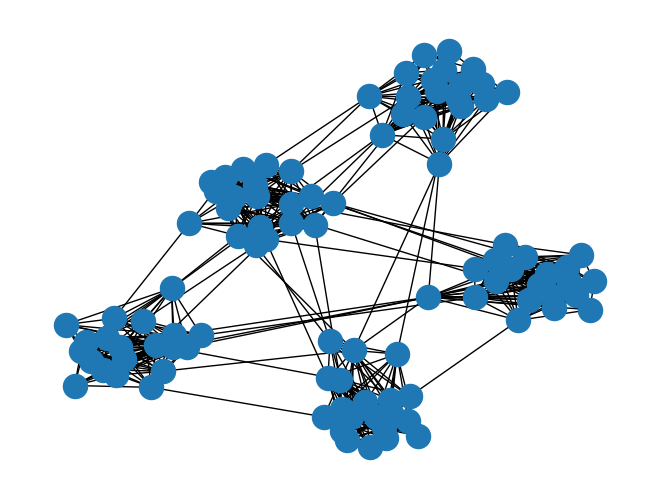

In [15]:
gl.plot_graph(dataset.graphs[122])

In [16]:
def laplacian(adj):
    return np.diag(adj.sum(1)) - adj

def adj_from_lap(lap):
    D = np.diag(np.diag(lap))
    return D - lap

In [17]:
def spectrum(mat, return_val=False):
    val, vec = np.linalg.eig(mat)
    idx = val.argsort()[::-1]   
    val = val[idx]
    vec = vec[:, idx]
    sqr_val = np.sqrt(val)
    sqr_val[np.isnan(sqr_val)] = 0.0
    vec = vec @ np.diag(sqr_val)
    if return_val:
        res = (vec, val)
    else:
        res = vec
    return res

In [18]:
def smallest_spectrum(mat, return_val=False):
    val, vec = np.linalg.eig(mat)
    idx = val.argsort()
    val = val[idx]
    vec = vec[:, idx]
    sqr_val = np.sqrt(val)
    sqr_val[np.isnan(sqr_val)] = 0.0
    vec = vec @ np.diag(sqr_val)
    if return_val:
        res = (vec, val)
    else:
        res = vec
    return res

In [19]:
def aprox(vec, K):
    return vec[:, :K] @ vec[:,:K].T

def mse(gt, pred):
    return ((gt - pred)**2).mean()

# def adjacency_error(adj_pred, adj_gt):
#     n_nodes = adj_gt.size(0)
#     adj_pred = (adj_pred > 0.5).type(torch.float32)
#     adj_errors = torch.abs(adj_pred - adj_gt)
#     wrong_edges = torch.sum(adj_errors)
#     adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
#     return wrong_edges.item(), adj_error.item()

def adjacency_error(adj_pred, adj_gt):
    n_nodes = adj_gt.shape[0]
    adj_pred = (adj_pred > 0.5).astype(float)
    adj_errors = np.abs(adj_pred - adj_gt)
    wrong_edges = np.sum(adj_errors)
    adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
    return wrong_edges, adj_error

# def adj_bce(pred, gt):
#     pred = np.clip(pred, 0, 1)
#     term_0 = (1-gt) * np.log(1-pred + 1e-10)
#     term_1 = gt * np.log(pred + 1e-10)
#     return -np.sum(term_0+term_1)

def adj_bce(pred, gt, reduce='sum', weight=None):
    if isinstance(pred, np.ndarray):
        pred = torch.Tensor(pred).clip(0, 1)
    if isinstance(gt, np.ndarray):
        gt = torch.Tensor(gt).clip(0, 1)
        
    return F.binary_cross_entropy(pred.view(-1, 1), gt.view(-1, 1), reduction=reduce, weight=weight)


In [20]:
def plot_graph(graph_nx):
#     graph_nx = graph2networkx(graph)
    pos = graph.pos
    if pos is not None:
        if pos[0].shape[0] > 2:
            pos = None

    nx.draw(graph_nx, pos=pos)
    plt.show()

In [21]:
adjs = []
for graph in dataset.graphs:
    _, _, _, adj_gt = graph.get_dense_graph(store=True, loops=False)
    adjs.append(adj_gt.numpy())

In [22]:
laps = []
for adj in adjs:
    laps.append(laplacian(adj))

In [49]:
eig = []
vals_appr = []
for lap in laps:
    vec, val_appr = spectrum(lap, return_val=True)
    eig.append(vec)
    vals_appr.append(val_appr)

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_70849/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [24]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()
d_bce = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    bces = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)
        adj_pred = np.clip(adj_pred, 0, 1)

        _, aerr = adjacency_error(adj_pred, adj_gt)
        aerrs.append(aerr)
        
        bce = adj_bce(adj_pred, adj_gt, 'mean')
        bces.append(bce)
    
    d[K] = np.array(aerrs)
    d_bce[K] = np.array(bces)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

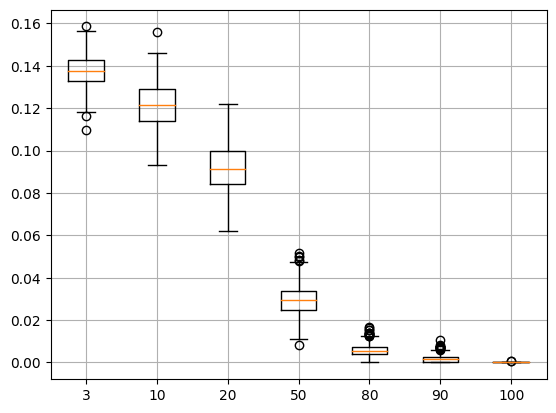

In [25]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

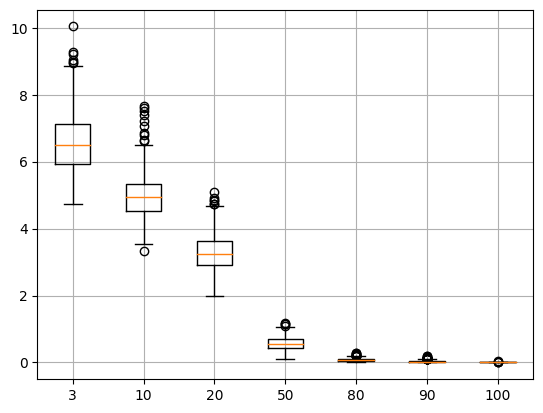

In [26]:
fig, ax = plt.subplots()
ax.boxplot(d_bce.values())
ax.grid()
ax.set_xticklabels(d.keys())

In [161]:
smalleig = []
for lap in laps:
    vec = smallest_spectrum(lap)
    smalleig.append(vec)

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_36199/2563491803.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [162]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()
d_bce = dict()

for K in Ks:
    
    approximations = []
    for vec in smalleig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    bces = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        _, aerr = adjacency_error(adj_pred, adj_gt)
        aerrs.append(aerr)
    
        bce = adj_bce(adj_pred, adj_gt, 'mean')
        bces.append(bce)
    
    d[K] = np.array(aerrs)
    d_bce[K] = np.array(bces)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

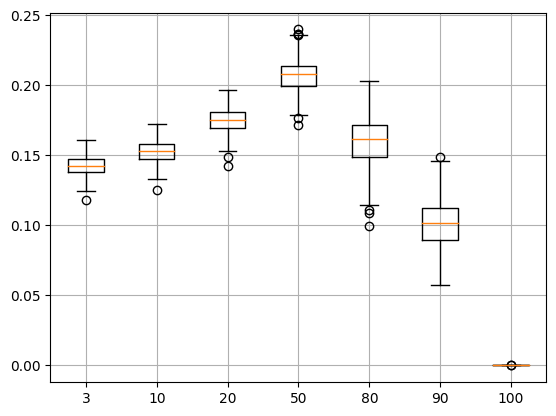

In [163]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

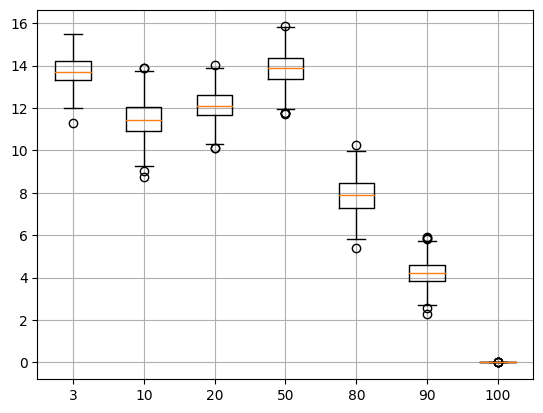

In [164]:
fig, ax = plt.subplots()
ax.boxplot(d_bce.values())
ax.grid()
ax.set_xticklabels(d.keys())

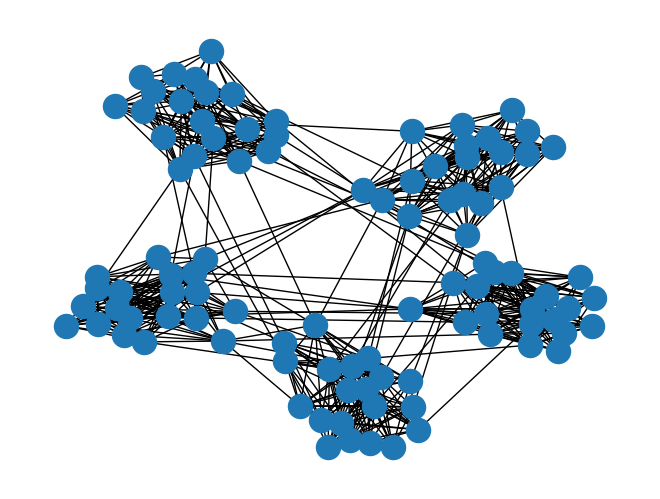

In [165]:
pred = adj_from_lap(aprox(eig[0], 100))
pred = np.clip(pred, 0, 1)
pred[pred < 1e-6] = 0
adj_gt = adjs[0]

plot_graph(nx.from_numpy_array(pred))

In [37]:
#Check reconstruction error from eigenvectors
#--------------------------------------------

In [166]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        aerr = adj_bce(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

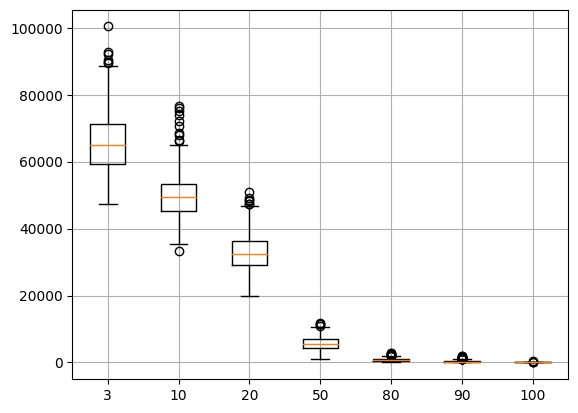

In [167]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

In [168]:
base = json.load(open(os.path.join(root_pth, 'output.json'), 'r'))

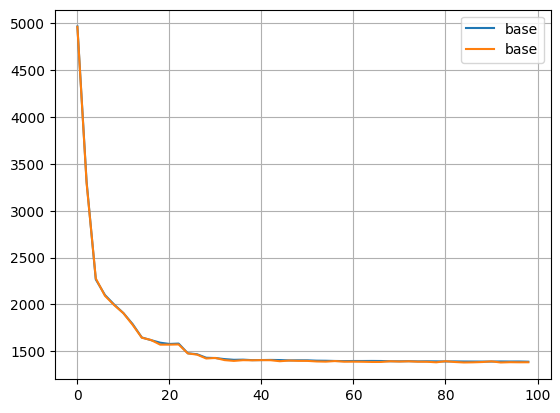

In [169]:
k = 0

plt.plot(base['train']['epoch'][k:], base['train']['bce'][k:], label='base')
plt.plot(base['val']['epoch'][k:], base['val']['bce'][k:], label='base')

plt.legend()
plt.grid()
plt.show()

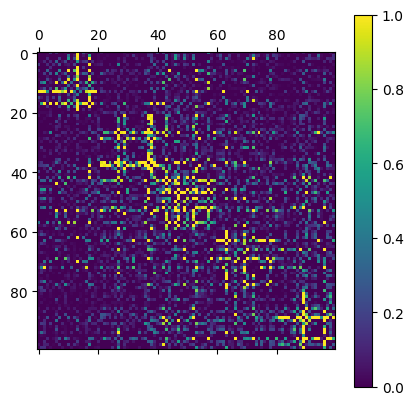

In [170]:
plt.matshow(p)
plt.colorbar()
plt.show()

In [27]:
# Load the model

In [249]:
root_pth

'/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_100_5comm/seed_1_K10/'

In [199]:
def torch_adj_bce(pred, gt, reduce='mean', weight=None):
    return F.binary_cross_entropy(pred.view(-1, 1), gt.view(-1, 1), reduction=reduce, weight=weight)

In [29]:
K = model_dict.get('K')
K

10

In [236]:
model_pth = os.path.join(root_pth, 'model.pt')
model = models.AE_EGNN(hidden_nf=nf, K=20, act_fn=nn.SiLU(), device=device, n_layers=n_layers,
                       reg=reg, clamp=clamp)

In [237]:
state_dict = torch.load(model_pth, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [238]:
model.eval()
rec = []
gt = []

test_bces = []
adj_errs = []

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        graph = data[0]
        n_nodes = graph.get_num_nodes()

        if with_pos:
            coords = graph.get_coords()
            coords = coords.to(device)
        else:
            coords = None

        nodes, edges, edge_attr, adj_gt = graph.get_dense_graph(store=True, loops=False)
        nodes, edges, edge_attr, adj_gt = nodes.to(device), [edges[0].to(device), edges[1].to(device)], edge_attr.to(device), adj_gt.to(device)

        adj_pred, mu = model(nodes, edges, coords, edge_attr)
        
        rec.append(adj_pred)
        gt.append(adj_gt)
        
        bce = torch_adj_bce(adj_pred, adj_gt)
        _, adj_err = eval.adjacency_error(adj_pred, adj_gt)
        
        test_bces.append(bce)
        adj_errs.append(adj_err)

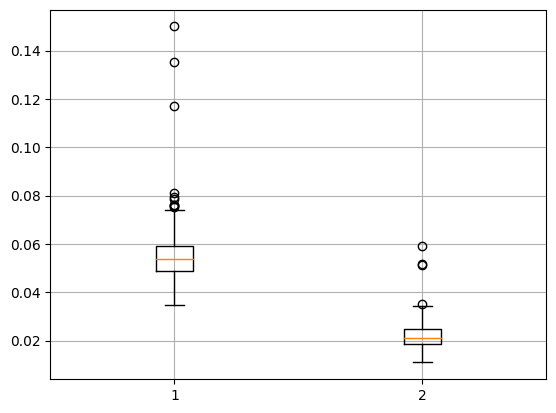

In [239]:
plt.boxplot({'bce': np.array(test_bces), 'adj_err': np.array(adj_errs)}.values())
plt.grid()

In [240]:
laps_p = []
laps_gt = []

for adj_p, adj_gt in zip(rec, gt):
    adj_p = adj_p.numpy()
    adj_gt = adj_gt.numpy()
    
    laps_p.append(laplacian(adj_p))
    laps_gt.append(laplacian(adj_gt))

In [241]:
len(laps_gt)

500

In [242]:
eig_p = []
eig_gt = []

for lap_p, lap_gt in zip(laps_p, laps_gt):
    eig_p.append(spectrum(lap_p, return_val=True))
    eig_gt.append(spectrum(lap_gt, return_val=True))

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_70849/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [243]:
len(eig_gt)

500

In [244]:
vals_p = []
vals_gt= []

vecs_p, vecs_gt = [], []

for i in range(25):
    vec_p, val_p = eig_p[i]
    vec_gt, val_gt = eig_gt[i]
    
    val_p.sort()
    val_gt.sort()
    
    vals_p.append(val_p)
    vals_gt.append(val_gt)
    
    vecs_p.append(vec_p)
    vecs_gt.append(vec_gt)
    

In [245]:
len(vecs_p)

25

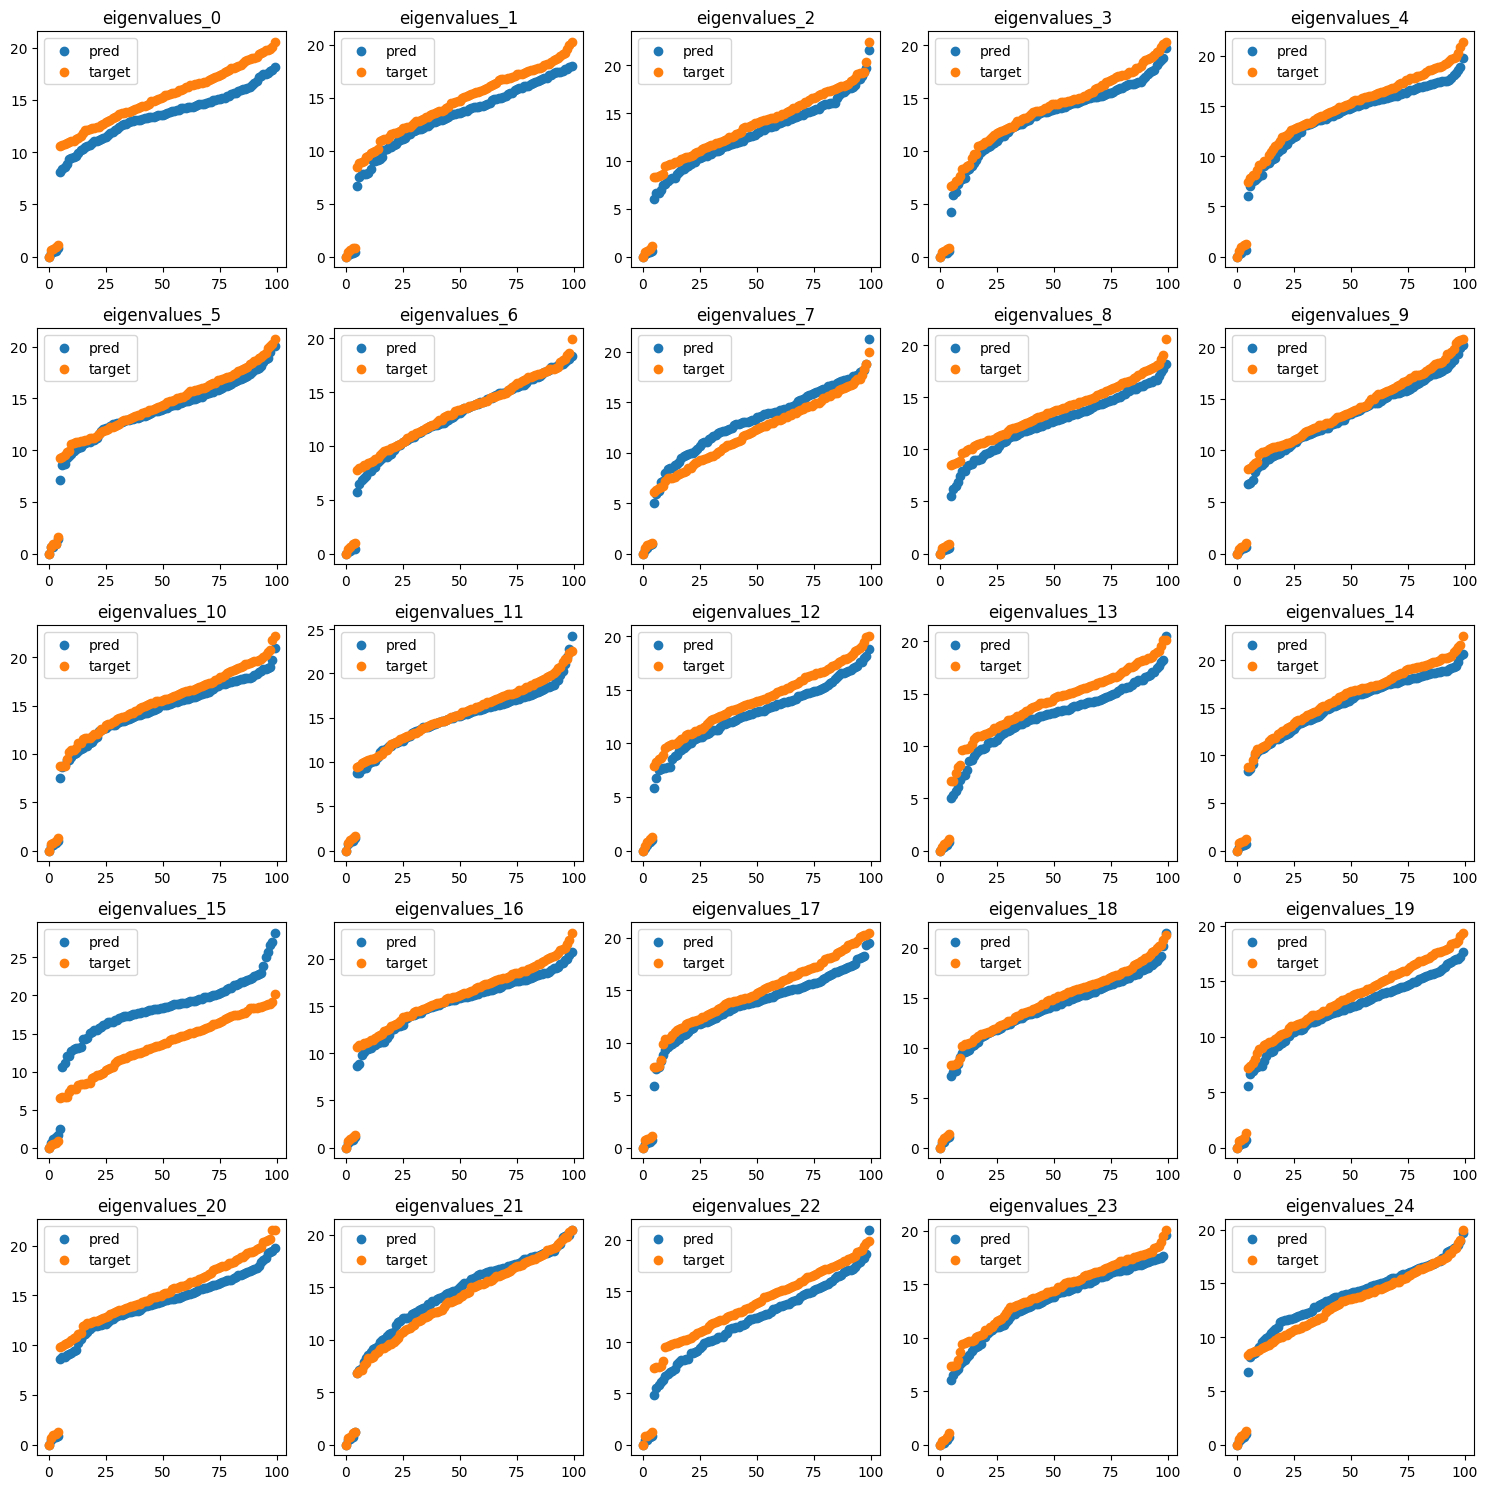

In [246]:
# Create a 6 x 5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Flatten the axs array for easier iteration
axs = axs.flatten()

domain = np.arange(100)


# Loop through each subplot and create a boxplot
for i, ax in enumerate(axs):
    title = 'eigenvalues_{}'.format(i)
    ax.scatter(domain, vals_p[i], label='pred')
    ax.scatter(domain, vals_gt[i], label='target')
    ax.set_title(title)
    ax.legend()
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# Remove empty subplots if necessary
if len(axs) > 5*5:
    for j in range(len(axs) - 5*5):
        axs[-1-j].remove()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show() 

In [168]:
approximations = []
for vec in eig:
    approximations.append(aprox(vec, 10))

In [169]:
laps_appr = approximations

In [170]:
eig_appr = []

for lap_p, lap_gt in zip(laps_appr, laps_gt):
    eig_appr.append(spectrum(lap_p, return_val=True))

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_70849/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [171]:
vals_p_appr = []
vecs_p_appr = []

for i in range(25):
    vec_p, val_p = eig_appr[i]

    val_p.sort()
    vals_p_appr.append(val_p)
    vecs_p_appr.append(vec_p)

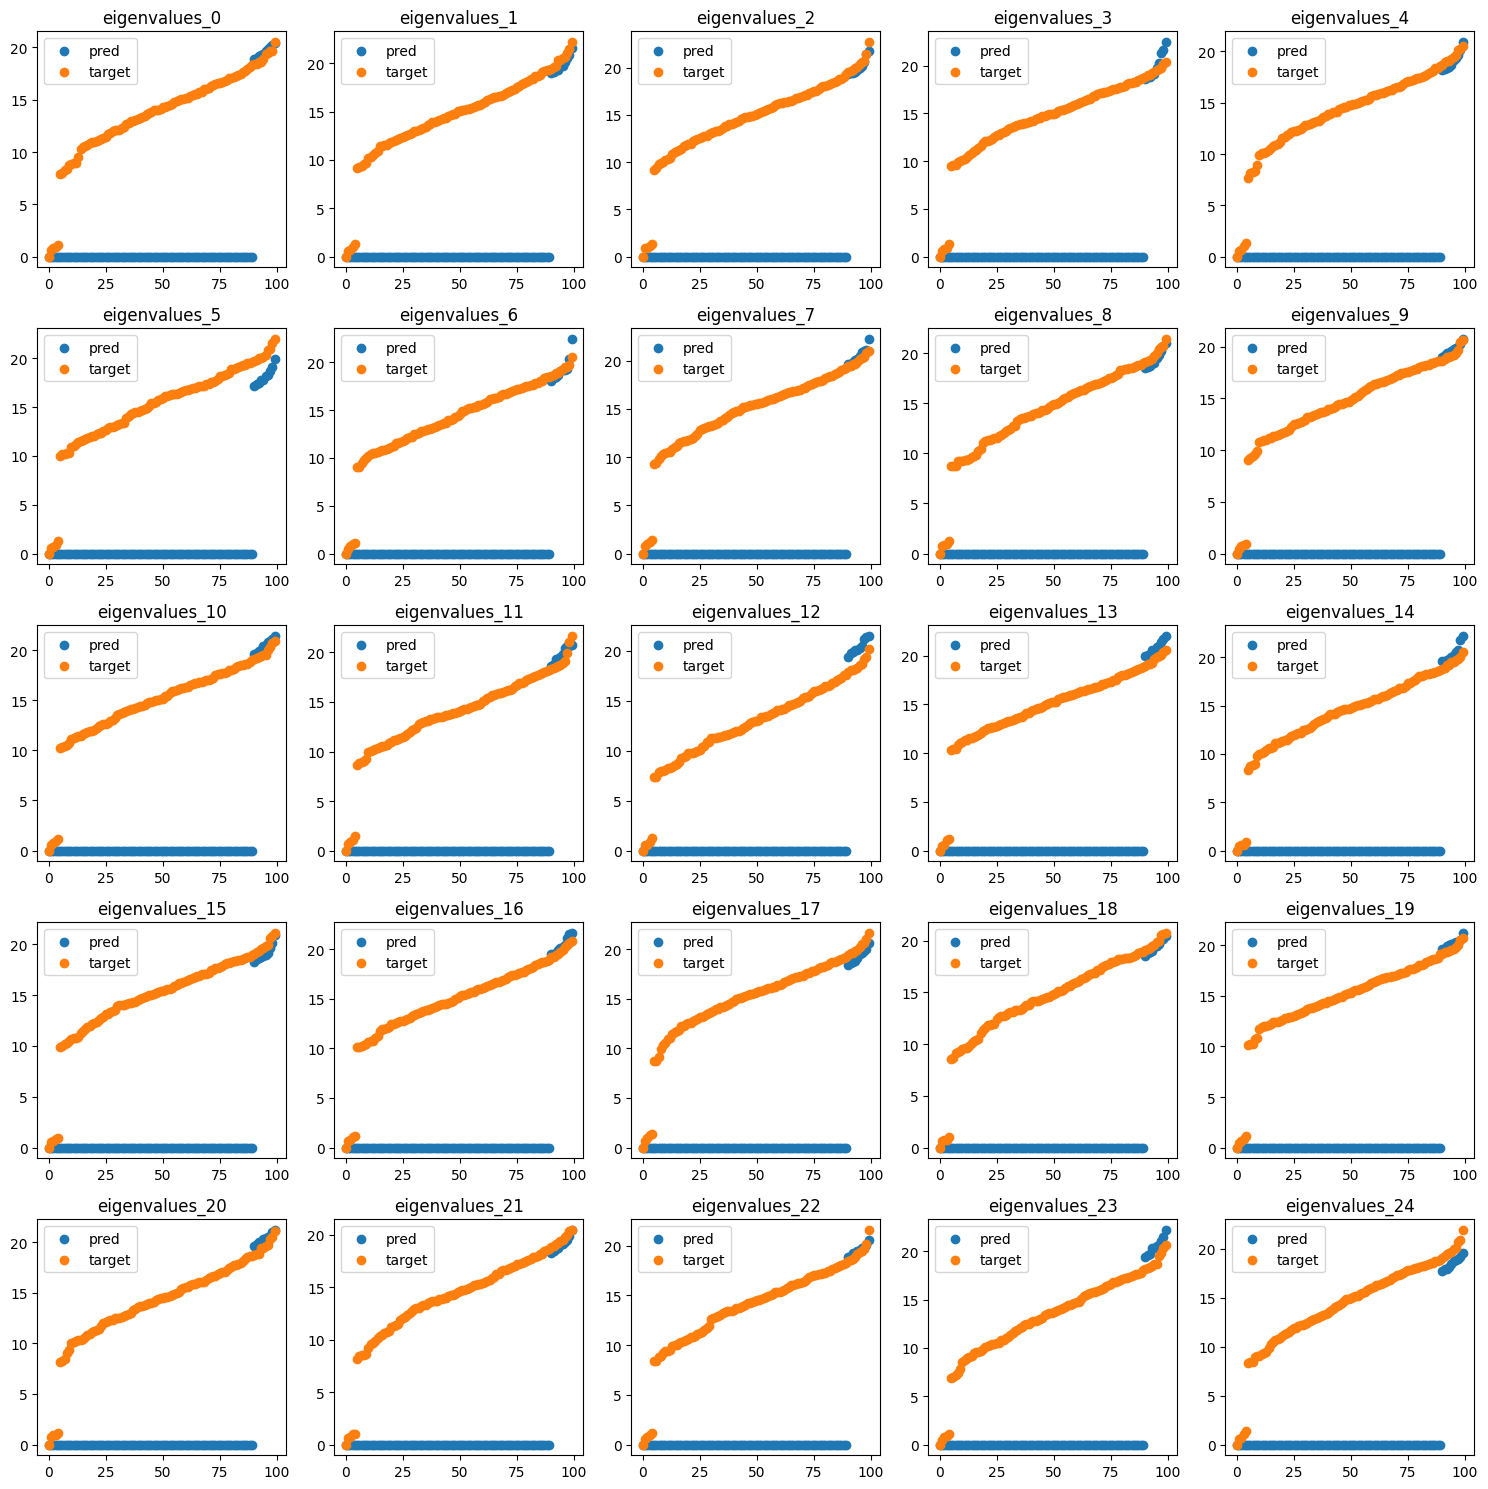

In [172]:
# Create a 6 x 5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Flatten the axs array for easier iteration
axs = axs.flatten()

domain = np.arange(100)


# Loop through each subplot and create a boxplot
for i, ax in enumerate(axs):
    title = 'eigenvalues_{}'.format(i)
    ax.scatter(domain, vals_p_appr[i], label='pred')
    ax.scatter(domain, vals_gt[i], label='target')
    ax.set_title(title)
    ax.legend()
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# Remove empty subplots if necessary
if len(axs) > 5*5:
    for j in range(len(axs) - 5*5):
        axs[-1-j].remove()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show() 

In [247]:
code = model.encode(nodes, edges, coords, edge_attr)

In [248]:
code.shape

torch.Size([100, 20])

In [252]:
recs = {}
bces_d = {}
adj_errs_d = {}

for k in [5, 10, 15, 20, 30]:

    model_pth = os.path.join(root_pth, 'model.pt')
    model = models.AE_EGNN(hidden_nf=nf, K=k, act_fn=nn.SiLU(), device=device, n_layers=n_layers,
                           reg=reg, clamp=clamp)

    state_dict = torch.load(model_pth, map_location=device)
    model.load_state_dict(state_dict)

    model.eval()
    rec = []
    gt = []

    test_bces = []
    adj_errs = []

    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            graph = data[0]
            n_nodes = graph.get_num_nodes()

            if with_pos:
                coords = graph.get_coords()
                coords = coords.to(device)
            else:
                coords = None

            nodes, edges, edge_attr, adj_gt = graph.get_dense_graph(store=True, loops=False)
            nodes, edges, edge_attr, adj_gt = nodes.to(device), [edges[0].to(device), edges[1].to(device)], edge_attr.to(device), adj_gt.to(device)

            adj_pred, mu = model(nodes, edges, coords, edge_attr)

            rec.append(adj_pred.numpy())
            gt.append(adj_gt)

            bce = torch_adj_bce(adj_pred, adj_gt)
            _, adj_err = eval.adjacency_error(adj_pred, adj_gt)

            test_bces.append(bce)
            adj_errs.append(adj_err)
            
    recs[k] = np.stack(rec)
    bces_d[k] = np.array(test_bces)
    adj_errs_d[k] = np.array(adj_errs)

In [259]:
aux = {}
aux[10] = bces_d[10]
aux[15] = bces_d[15]
aux[20] = bces_d[20]

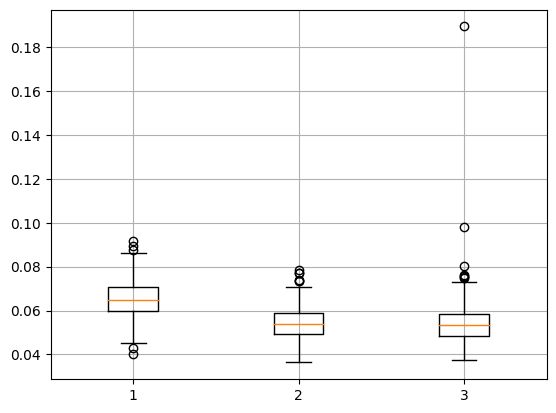

In [260]:
plt.boxplot(aux.values())
plt.grid()

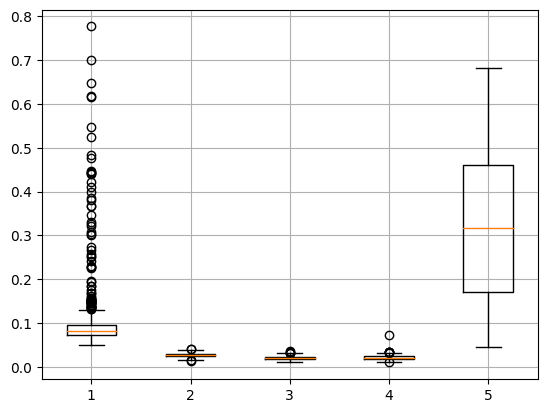

In [261]:
plt.boxplot(adj_errs_d.values())
plt.grid()